In [1]:
import os
import tqdm
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.view(-1)

In [4]:
cuda_id = 0
device_name = "cuda:{}".format(cuda_id) if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

In [5]:
epochs = 200
batch_size = 128
lr = 0.0002
latent_dim = 100

In [6]:
dataloader = data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(0.5, 0.5)
                   ])),
    batch_size=batch_size, shuffle=True)
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

100%|██████████| 9912422/9912422 [00:00<00:00, 90566263.62it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75380021.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26083923.20it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1177121.15it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
generator

Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [8]:
discriminator

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
def generate(generator, epoch):
    if not os.path.exists('img'):
        os.mkdir('img')
    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')
    generator.eval()
    noise = torch.randn(64, latent_dim).to(device)
    with torch.no_grad():
        fake = generator(noise)
    fake = fake.view(-1, 1, 28, 28)
    img_grid_fake = make_grid(fake, normalize=True)
    plt.imshow(np.transpose(img_grid_fake.cpu(), (1, 2, 0)))
    plt.title(f'epoch {epoch} | fake images')
    plt.axis('off')
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

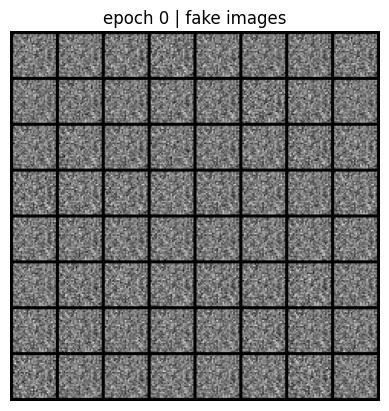

 20%|█▉        | 39/200 [11:14<45:44, 17.05s/it]

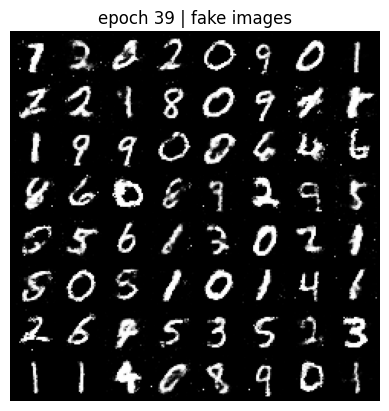

 40%|███▉      | 79/200 [22:47<34:24, 17.06s/it]

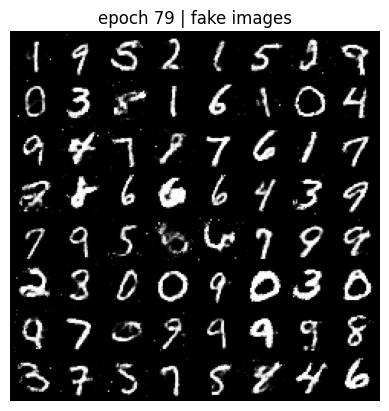

 60%|█████▉    | 119/200 [34:18<23:29, 17.40s/it]

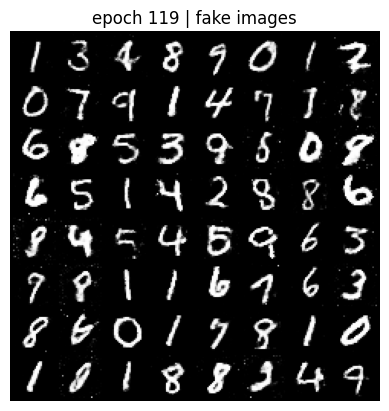

 80%|███████▉  | 159/200 [45:50<11:39, 17.06s/it]

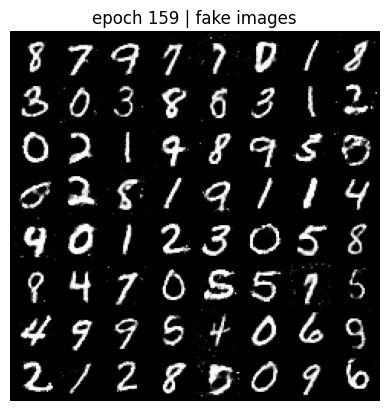

100%|█████████▉| 199/200 [57:29<00:17, 17.34s/it]

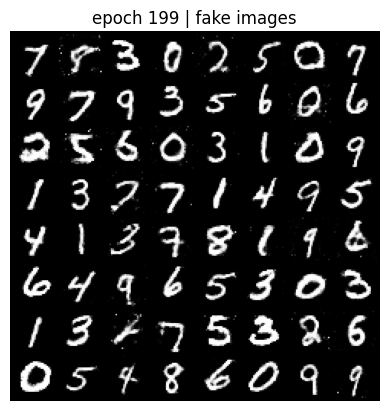

100%|██████████| 200/200 [57:46<00:00, 17.33s/it]


In [10]:
errors_d = []
errors_g = []
for epoch in tqdm.tqdm(range(epochs)):
    avg_error_d = 0
    avg_error_g = 0
    if epoch == 0 or (epoch + 1) % 40 == 0:
        generate(generator, epoch)
    img = None
    generator.train()
    for i, (img, _) in enumerate(dataloader):
        img = img.view(-1, 784).to(device)
        n_samples = img.shape[0]
        true_labels = torch.ones(n_samples).to(device)
        fake_labels = torch.zeros(n_samples).to(device)
        true_output = discriminator(img)
        error_d_real = criterion(true_output, true_labels)
        noise = torch.randn(n_samples, latent_dim).to(device)
        fake_img = generator(noise).detach()
        fake_output = discriminator(fake_img)
        error_d_fake = criterion(fake_output, fake_labels)
        error_d = error_d_real + error_d_fake
        avg_error_d += error_d.item()
        optimizer_d.zero_grad()
        error_d.backward()
        optimizer_d.step()
        noise = torch.randn(n_samples, latent_dim).to(device)
        fake_img = generator(noise)
        fake_output = discriminator(fake_img)
        error_g = criterion(fake_output, true_labels)
        avg_error_g += error_g.item()
        optimizer_g.zero_grad()
        error_g.backward()
        optimizer_g.step()
    avg_error_d /= len(dataloader)
    avg_error_g /= len(dataloader)
    errors_d.append(avg_error_d)
    errors_g.append(avg_error_g)
torch.save(generator.state_dict(), 'checkpoints/generator.pkl')

In [11]:
def draw(errors_d, errors_g):
    plt.plot(errors_d, label='discriminator')
    plt.plot(errors_g, label='generator')
    plt.legend()
    plt.title('loss')
    plt.show()

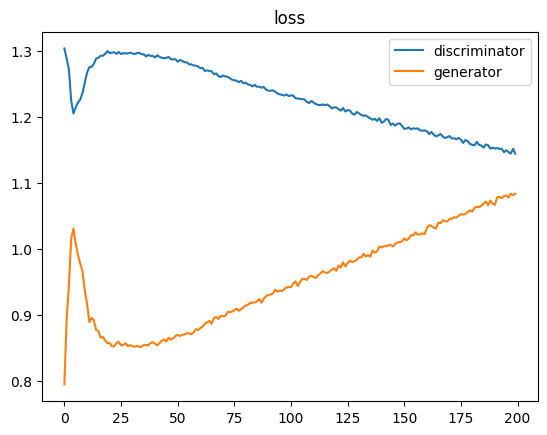

In [12]:
draw(errors_d, errors_g)

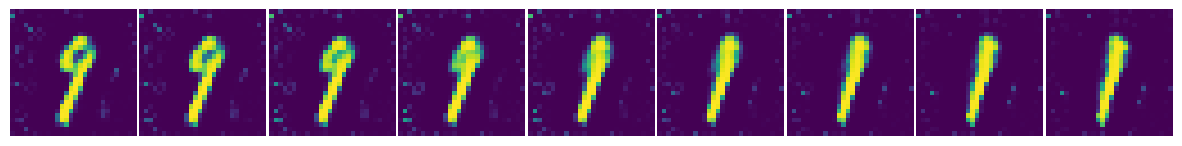

In [14]:
model = Generator().to(device)
model.load_state_dict(torch.load('checkpoints/generator.pkl'))
model.eval()
noise0 = torch.zeros(1, latent_dim).to(device)
noise1 = torch.ones(1, latent_dim).to(device)
noises = [noise0]
for i in range(1, 8):
    alpha = i / 8
    noise = alpha * noise1 + (1 - alpha) * noise0
    noises.append(noise)
noises.append(noise1)
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(15, 3))
for i, noise in enumerate(noises):
    with torch.no_grad():
        fake = model(noise)
    fake = fake.view(-1, 1, 28, 28)
    image = np.transpose(fake.cpu().numpy()[0], (1, 2, 0))
    axes[i].imshow(image)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.02)
plt.show()